In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

from _cd_diagram import draw_cd_diagram

# Getting some free samples
results_df.sample(3)

# Don't change any code below, it may break (probably will) --------------------



['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Top Down 1e-2', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Top Down', 'Top Down 1e-0']
(899, 14)
['Top Down (only last)' 'Without simplify' 'Bottom Up'
 'Bottom Up (only last)' 'Top Down']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']


,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth
456,Top Down (only last),Energy Heating,0,27690,641.058926,01-21-2024 22:01:18,0.920874,0.926085,7.125884,6.996055,"multiply(add(116.19116625957582, x_2), cdiv(add(x_4, -0.5682377811670075), cdiv(137.65548072968303, multiply(1.66833002311936, sqrtabs(sqrtabs(x_6))))))",15,32,6
358,Without simplify,Energy Cooling,0,6933,301.158988,01-21-2024 20:00:10,0.874690,0.882035,10.255015,9.344480,"multiply(add(subtract(196.00798817485503, multiply(x_6, -365.1838044636169)), x_2), multiply(x_4, 0.007709987914708507))",11,15,4
170,Top Down (only last),Concrete,0,26311,1015.497602,01-21-2024 21:59:29,0.548889,0.412056,77.944862,85.267441,"add(multiply(20.521284528441406, log(log1p(x_7))), multiply(subtract(subtract(x_3, multiply(x_1, 0.5640044571610537)), x_0), -0.09956947387302702))",15,146,5


criteria              Harmonic Mean size mean score                      \
                               mean              lb      mean        ub   
model                                                                     
Top Down (only last)       3.029161        2.547503  2.891762  3.236022   
Top Down                   3.006957        3.075117  3.325000  3.574883   
Without simplify           2.977634        2.298668  2.683333  3.067999   
Bottom Up (only last)      2.965032        2.759609  2.813889  2.868169   
Bottom Up                  2.890721        2.873601  3.272222  3.670843   

criteria              test_mse mean score                      
                                       lb      mean        ub  
model                                                          
Top Down (only last)             2.876544  3.180268  3.483992  
Top Down                         2.403853  2.744444  3.085036  
Without simplify                 3.115212  3.344444  3.573677  
Bottom Up (only last)            2.989207  3.133333  3.277459  
Bottom Up                        2.192325  2.588889  2.985452

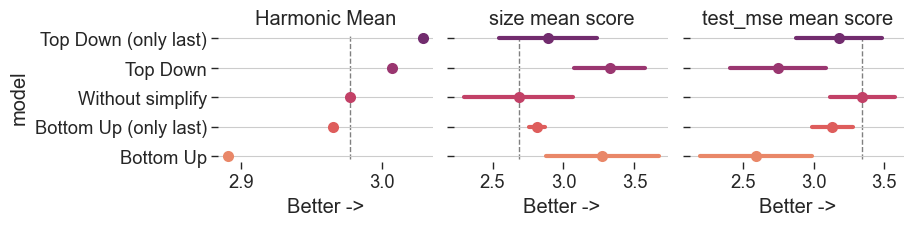

criteria              Harmonic Mean complexity mean score                      \
                               mean                    lb      mean        ub   
model                                                                           
Top Down                   3.167680              3.210855  3.375000  3.539145   
Bottom Up                  3.093241              3.067455  3.202778  3.338100   
Top Down (only last)       2.942561              2.709032  2.840613  2.972194   
Bottom Up (only last)      2.912341              2.685459  2.816667  2.947874   
Without simplify           2.795651              2.584425  2.752778  2.921130   

criteria              depth mean score                     size mean score  \
                                    lb      mean        ub              lb   
model                                                                        
Top Down                      2.958258  3.272222  3.586187        3.075117   
Bottom Up                     2.961277  3.166667  3.372056        2.873601   
Top Down (only last)          2.690438  2.941762  3.193087        2.547503   
Bottom Up (only last)         2.833308  2.966667  3.100025        2.759609   
Without simplify              2.374849  2.641667  2.908484        2.298668   

criteria                                  test_mse mean score            \
                           mean        ub                  lb      mean   
model                                                                     
Top Down               3.325000  3.574883            2.403853  2.744444   
Bottom Up              3.272222  3.670843            2.192325  2.588889   
Top Down (only last)   2.891762  3.236022            2.876544  3.180268   
Bottom Up (only last)  2.813889  2.868169            2.989207  3.133333   
Without simplify       2.683333  3.067999            3.115212  3.344444   

criteria                        test_r2 mean score                      
                             ub                 lb      mean        ub  
model                                                                   
Top Down               3.085036           2.915227  3.211111  3.506995  
Bottom Up              2.985452           3.023070  3.372222  3.721374  
Top Down (only last)   3.483992           2.692928  2.881992  3.071056  
Bottom Up (only last)  3.277459           2.659801  2.855556  3.051310  
Without simplify       3.573677           2.427512  2.666667  2.905822

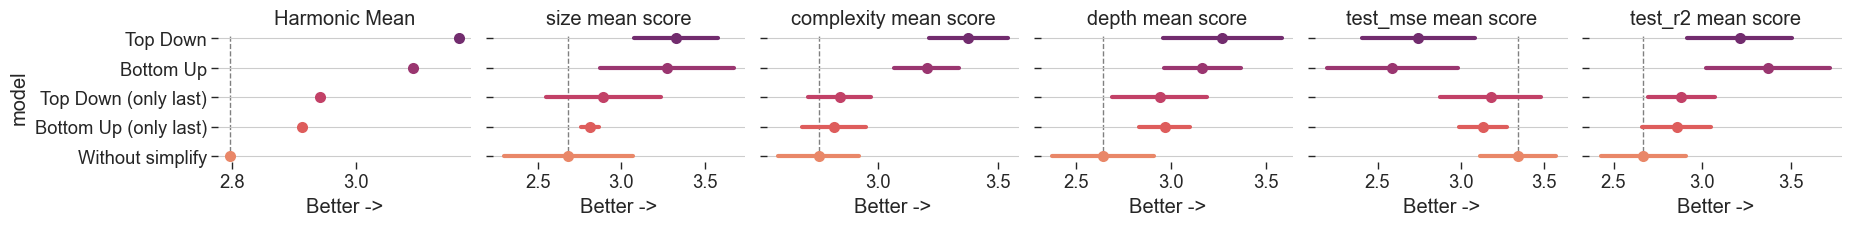

criteria              Harmonic Mean complexity mean score                      \
                               mean                    lb      mean        ub   
model                                                                           
Top Down                   3.167680              3.210855  3.375000  3.539145   
Bottom Up                  3.093241              3.067455  3.202778  3.338100   
Top Down (only last)       2.942561              2.709032  2.840613  2.972194   
Bottom Up (only last)      2.912341              2.685459  2.816667  2.947874   
Without simplify           2.795651              2.584425  2.752778  2.921130   

criteria              depth mean score                     size mean score  \
                                    lb      mean        ub              lb   
model                                                                        
Top Down                      2.958258  3.272222  3.586187        3.075117   
Bottom Up                     2.961277  3.166667  3.372056        2.873601   
Top Down (only last)          2.690438  2.941762  3.193087        2.547503   
Bottom Up (only last)         2.833308  2.966667  3.100025        2.759609   
Without simplify              2.374849  2.641667  2.908484        2.298668   

criteria                                  test_mse mean score            \
                           mean        ub                  lb      mean   
model                                                                     
Top Down               3.325000  3.574883            2.403853  2.744444   
Bottom Up              3.272222  3.670843            2.192325  2.588889   
Top Down (only last)   2.891762  3.236022            2.876544  3.180268   
Bottom Up (only last)  2.813889  2.868169            2.989207  3.133333   
Without simplify       2.683333  3.067999            3.115212  3.344444   

criteria                        test_r2 mean score                      
                             ub                 lb      mean        ub  
model                                                                   
Top Down               3.085036           2.915227  3.211111  3.506995  
Bottom Up              2.985452           3.023070  3.372222  3.721374  
Top Down (only last)   3.483992           2.692928  2.881992  3.071056  
Bottom Up (only last)  3.277459           2.659801  2.855556  3.051310  
Without simplify       3.573677           2.427512  2.666667  2.905822

In [2]:
def plot_rankings(columns, results_df, path):
    ranks_data = []
    for col in columns:
        ranks_df = results_df.pivot( # Smaller is better for all columns here
            index=['dataset', 'RunID', 'random_state'], columns='model', values=col
        ).rank(ascending=False, axis=1).groupby('dataset').mean()#.rank(ascending=False, axis=1)
        
        for model in results_df['model'].unique():
            df_model = ranks_df[ model ]
            values = df_model.values

            # Estimating lower and upper confidence bounds
            lb, ub = stats.norm.interval(confidence=0.95, loc=np.mean(values),
                                        scale=stats.sem(values))
            lb = np.nan_to_num(lb, 0.0)
            ub = np.nan_to_num(ub, 0.0)

            ranks_data.append( (model, f'{col} mean score', df_model.mean(), lb, ub) )

    # Creating the dataframe
    ranks_data_df = pd.DataFrame(data=ranks_data,
                                columns=['model', 'criteria', 'mean', 'lb', 'ub'])

    ranks_data_df = ranks_data_df.pivot(columns='criteria', index='model')

    # will calculate the harmonic mean and plot the columns based on mean rankings
    ranks_data_df[('mean', 'Harmonic Mean')] = (
        ranks_data_df[[('mean', f'{col} mean score') for col in columns]]
    )['mean'].apply(stats.hmean, axis=1)

    ranks_data_df = ranks_data_df.sort_values(by=('mean', 'Harmonic Mean'), ascending=False)
    ranks_data_df = ranks_data_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    display(ranks_data_df)
    #print(ranks_data_df.to_latex())

    # Use semantically meaningful titles for the columns
    titles = ['Harmonic Mean']+[f'{col} mean score' for col in columns]

    # Now making the plot
    g = sns.PairGrid(ranks_data_df.reorder_levels([1, 0], axis=1)['mean'].reset_index(),
                    x_vars=titles, y_vars=['model'], height=2.5, aspect=1.25)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=8, orient="h", jitter=False,
        palette="flare_r", linewidth=0, edgecolor="w")

    # setting the reference as the Baseline 
    unif = ((ranks_data_df[ ranks_data_df.index=='Without simplify'])['Harmonic Mean'])['mean'].values[0]
    g.axes.flat[0].axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

    g.axes.flat[0].set(title='Harmonic Mean')
    g.axes.flat[0].set_xlabel('Better ->')
    #g.axes.flat[0].set_xlim( (-1, len(ranks_data_df.index)+1) )

    # Make the grid horizontal instead of vertical
    g.axes.flat[0].xaxis.grid(False)
    g.axes.flat[0].yaxis.grid(True)

    for ax, title in zip(g.axes.flat[1:], titles[1:]):
        color = iter(sns.color_palette("flare_r", ranks_data_df.shape[0]))
        for tick, text in zip(g.axes.flat[0].get_yticks(), g.axes.flat[0].get_yticklabels()):
            c=next(color)
            sample_name = text.get_text()  # "X" or "Y"
            single_df = ranks_data_df[ ranks_data_df.index==sample_name ]
            
            lb, ub, mean_val = (single_df[title])[ ['lb', 'ub', 'mean'] ].values[0]
            rank_val = ranks_data_df.reset_index()[(ranks_data_df.reset_index()['model']==sample_name)].index

            # plot horizontal lines across the column, centered on the tCIk
            ax.plot([lb, ub], [rank_val, rank_val], lw=3, color=c)

        # Draw a reference line on baseline
        unif = (ranks_data_df[ ranks_data_df.index=='Without simplify'])[(title, 'mean')].values[0]
        ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

        # Set a different title for each axes
        ax.set(title=title)
        ax.set_xlabel('Better ->')
        #ax.set_xlim( (-1, len(ranks_data_df.index)+1) )

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.savefig(f'{path}.pdf')
    plt.savefig(f'{path}.png', dpi=600)

    plt.show()

    return ranks_data_df

plot_rankings(['size', 'test_mse'], results_df, "../paper/figs/size_mse")
plot_rankings(['size', 'complexity', 'depth', 'test_mse', 'test_r2'], results_df, "../paper/figs/size_mse_compexity_depth")
